# Importuri

In [151]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import xgboost
from scipy.stats import entropy as en
import math
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model



# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import RandomOverSampler

# Customer Churn

## Dataset-ul

Pentru acest proiect am ales un dataset cu datele unei "companii" de telco. Datasetul este preluat de pe site-ul Kaggle: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

clienții care au plecat în ultima lună - coloana se numește Churn
serviciile la care fiecare client s-a înscris - telefon, multi-line, internet, securitate online, backup online, protecție dispozitive, asistență tehnică și streaming TV/filme.
informații despre contul clientului - cât timp au fost clienți, contract, metodă de plată, facturare electronică, taxe lunare/totale
informații demografice despre clienți - gen, vârstă, parteneri și dependenți

## Preluarea datelor



In [68]:
#reading csv
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv", delimiter=",", na_values=" ")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Transformarea outputului din yes/no in int

In [69]:
df["Churn"] = (df["Churn"] == 'Yes').astype(int)

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [70]:
df.shape

(7043, 21)

Pentru ca modelul ml sa funcioneze trebuie ca anumite coloane sa fie convertite in numere(0 si 1 ex.gender 0 masulin si 1 feminin) iar altele sa fie impartie in 2(ex. internet service a fost impartit in 2 coloane, una cu dsl si una cu fibra optica ):

In [71]:
df = df.replace({"No internet service":"No"})
df = df.replace({"No phone service":"No"})
df = df.replace({",,":"NaN"})
df['gender'] = df['gender'].replace({'Male': 0, 'Female': 1})
df["Partner"] = (df["Partner"] == 'Yes').astype(int)
df["Dependents"] = (df["Dependents"] == 'Yes').astype(int)
df["PhoneService"] = (df["PhoneService"] == 'Yes').astype(int)
df["MultipleLines"] = (df["MultipleLines"] == 'Yes').astype(int)
df["OnlineSecurity"] = (df["OnlineSecurity"] == 'Yes').astype(int)
df["OnlineBackup"] = (df["OnlineBackup"] == 'Yes').astype(int)
df["DeviceProtection"] = (df["DeviceProtection"] == 'Yes').astype(int)
df["TechSupport"] = (df["TechSupport"] == 'Yes').astype(int)
df["StreamingTV"] = (df["StreamingTV"] == 'Yes').astype(int)
df["StreamingMovies"] = (df["StreamingMovies"] == 'Yes').astype(int)
df["PaperlessBilling"] = (df["PaperlessBilling"] == 'Yes').astype(int)

# One-hot encoding for InternetService
internet_service_dummies = pd.get_dummies(df['InternetService'], prefix='InternetService')
df = pd.concat([df, internet_service_dummies], axis=1)

# One-hot encoding for Contract
contract_dummies = pd.get_dummies(df['Contract'], prefix='Contract')
df = pd.concat([df, contract_dummies], axis=1)

# One-hot encoding for PaymentMethod
payment_method_dummies = pd.get_dummies(df['PaymentMethod'], prefix='PaymentMethod')
df = pd.concat([df, payment_method_dummies], axis=1)

# Convert True and False to 1 and 0
df = df.applymap(lambda x: 1 if x == True else (0 if x == False else x))

# Drop original categorical columns
df.drop(['InternetService', 'Contract', 'PaymentMethod'], axis=1, inplace=True)
df

C:\Users\march\AppData\Local\Temp\ipykernel_24368\2812054346.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace({'Male': 0, 'Female': 1})
C:\Users\march\AppData\Local\Temp\ipykernel_24368\2812054346.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: 1 if x == True else (0 if x == False else x))


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,0,1,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0
1,5575-GNVDE,0,0,0,0,34,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,0,0,0,0,2,1,0,1,1,...,1,0,0,1,0,0,0,0,0,1
3,7795-CFOCW,0,0,0,0,45,0,0,1,0,...,1,0,0,0,1,0,1,0,0,0
4,9237-HQITU,1,0,0,0,2,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,0,1,1,24,1,1,1,0,...,1,0,0,0,1,0,0,0,0,1
7039,2234-XADUH,1,0,1,1,72,1,1,0,1,...,0,1,0,0,1,0,0,1,0,0
7040,4801-JZAZL,1,0,1,1,11,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
7041,8361-LTMKD,0,1,1,0,4,1,1,0,0,...,0,1,0,1,0,0,0,0,0,1


# Correlation matrix

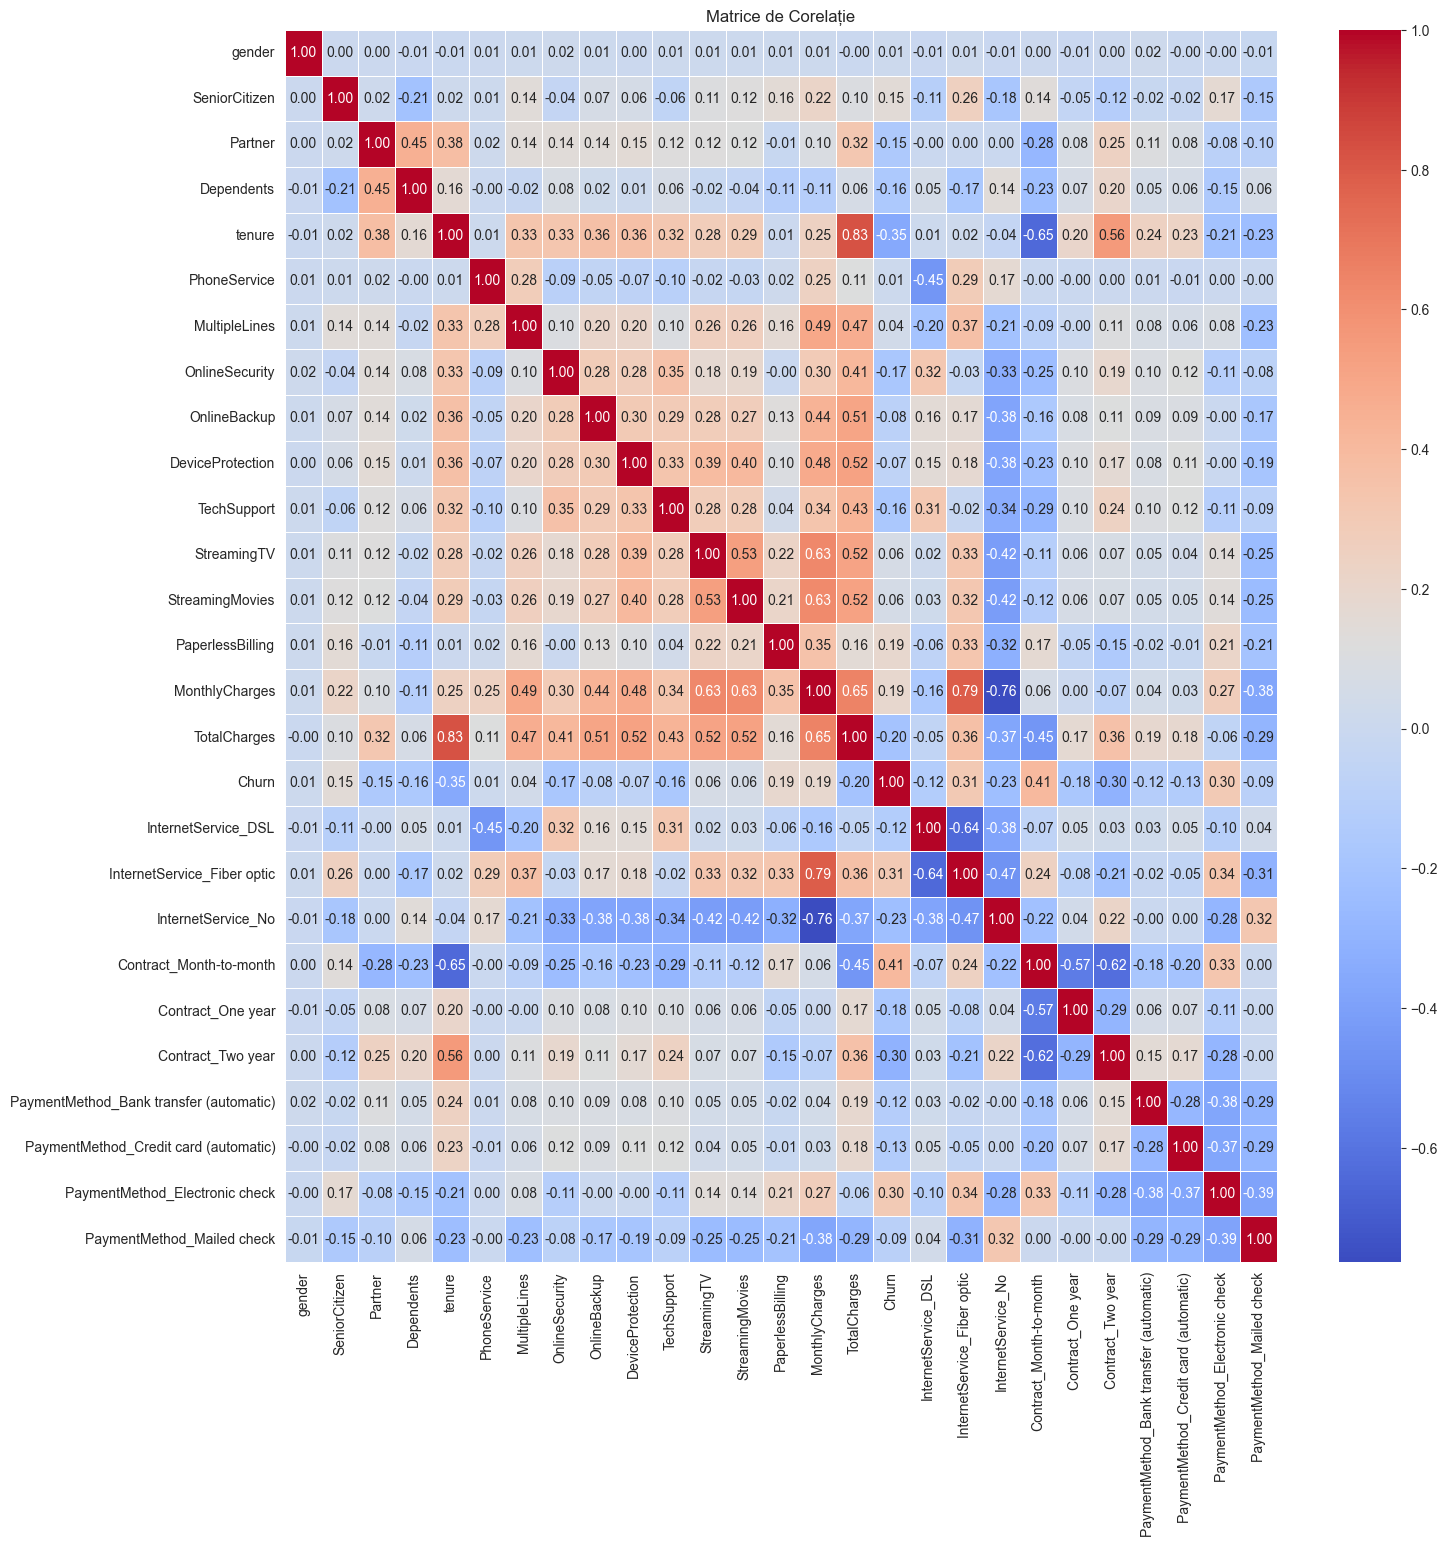

In [72]:
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(16, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de Corelație')
plt.show()

# Histograma datelor

## Aici se poate observa distibutia datelor

In [73]:
# for label in df[:-1]:
#     plt.hist(df[df["Churn"]==1][label], color='b', label='Yes', alpha=0.7, density=True)
#     plt.hist(df[df["Churn"]==0][label], color='r', label='No', alpha=0.7, density=True)
#     plt.title(label)
#     plt.ylabel("probability")
#     plt.xlabel(label)
#     plt.legend()
#     plt.show()


In [74]:
df.shape #rows, columns

(7043, 28)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   customerID                               7043 non-null   object 
 1   gender                                   7043 non-null   int64  
 2   SeniorCitizen                            7043 non-null   int64  
 3   Partner                                  7043 non-null   int64  
 4   Dependents                               7043 non-null   int64  
 5   tenure                                   7043 non-null   int64  
 6   PhoneService                             7043 non-null   int64  
 7   MultipleLines                            7043 non-null   int64  
 8   OnlineSecurity                           7043 non-null   int64  
 9   OnlineBackup                             7043 non-null   int64  
 10  DeviceProtection                         7043 no

# Data Cleaning


Datele nu sunt citite intaocmai cum au fost puse in csv, asadar a fost nevoie sa folosesc comanda replace pentru a gasii valorile null

In [76]:
df.isnull()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7039,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7040,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7041,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [77]:
df.isnull().sum()

customerID                                  0
gender                                      0
SeniorCitizen                               0
Partner                                     0
Dependents                                  0
tenure                                      0
PhoneService                                0
MultipleLines                               0
OnlineSecurity                              0
OnlineBackup                                0
DeviceProtection                            0
TechSupport                                 0
StreamingTV                                 0
StreamingMovies                             0
PaperlessBilling                            0
MonthlyCharges                              0
TotalCharges                               11
Churn                                       0
InternetService_DSL                         0
InternetService_Fiber optic                 0
InternetService_No                          0
Contract_Month-to-month           

In [78]:
df.isnull().sum().sum()

11

## Stergerea datelor cu valori NaN

In [79]:
df.dropna(inplace=True)

In [80]:
df.isna().sum().sum()

0

In [81]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,0,1,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0
1,5575-GNVDE,0,0,0,0,34,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,0,0,0,0,2,1,0,1,1,...,1,0,0,1,0,0,0,0,0,1
3,7795-CFOCW,0,0,0,0,45,0,0,1,0,...,1,0,0,0,1,0,1,0,0,0
4,9237-HQITU,1,0,0,0,2,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,0,1,1,24,1,1,1,0,...,1,0,0,0,1,0,0,0,0,1
7039,2234-XADUH,1,0,1,1,72,1,1,0,1,...,0,1,0,0,1,0,0,1,0,0
7040,4801-JZAZL,1,0,1,1,11,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
7041,8361-LTMKD,0,1,1,0,4,1,1,0,0,...,0,1,0,1,0,0,0,0,0,1



## Entropy

Entropia este o măsură a incertitudinii sau a dezordonării într-un set de date. Cu cât entropia este mai mare, cu atât incertitudinea este mai mare și, implicit, informația conținută în setul de date este mai mare.

In [82]:
en(df.value_counts())

8.858226439365012

In [83]:
def entropy(labels):
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    probabilities = label_counts / len(labels)
    entropy_value = -np.sum(probabilities * np.log2(probabilities))
    return entropy_value

for label in df[:-1]:
    print(label, entropy(df[label]))



customerID 12.779719355143406
gender 0.9999364550464405
SeniorCitizen 0.6400214027212845
Partner 0.9991170306066908
Dependents 0.8794404586827863
tenure 5.914257891990094
PhoneService 0.45844925718753027
MultipleLines 0.9823408405367391
OnlineSecurity 0.8642191874399958
OnlineBackup 0.9293863281716901
DeviceProtection 0.9284615332282073
TechSupport 0.8688534723572245
StreamingTV 0.9610806778229317
StreamingMovies 0.9637379297728217
PaperlessBilling 0.9750506859651258
MonthlyCharges 10.03978145590052
TotalCharges 12.612577727899449
Churn 0.835351115333023
InternetService_DSL 0.9281961426694367
InternetService_Fiber optic 0.9896822991083725
InternetService_No 0.7530837185380153
Contract_Month-to-month 0.9924665688282985
Contract_One year 0.7401977722036489
Contract_Two year 0.7944059240036077
PaymentMethod_Bank transfer (automatic) 0.7588566257578604
PaymentMethod_Credit card (automatic) 0.7533479249119055
PaymentMethod_Electronic check 0.9212532758241578
PaymentMethod_Mailed check 0.774

## Gini Index
Indicele Gini este o măsură a inegalității sau impurității într-un set de date și este folosit în algoritmi de clasificare pentru a determina cea mai bună caracteristică de separare a datelor. Cu cât indicele Gini este mai mic, cu atât este mai bine separat setul de date.

In [84]:
def gini_index(labels):
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    probabilities = label_counts / len(labels)
    gini_value =  np.sum(probabilities**2)
    return gini_value

for label in df[:-1]:
    print(label, gini_index(df[label]))

customerID 0.00014220705346985204
gender 0.5000440453587113
SeniorCitizen 0.7279469054839183
Partner 0.5006119028759799
Dependents 0.5812104602913902
tenure 0.02245455845599703
PhoneService 0.8253004953141239
MultipleLines 0.512190372048597
OnlineSecurity 0.5911241847766298
OnlineBackup 0.548141738854138
DeviceProtection 0.5487614881943879
TechSupport 0.5881140141411083
StreamingTV 0.5267333486703398
StreamingMovies 0.5249236466224287
PaperlessBilling 0.5171936255000705
MonthlyCharges 0.001504417963840904
TotalCharges 0.00017504895546573368
Churn 0.6097133484373725
InternetService_DSL 0.5489392874569172
InternetService_Fiber optic 0.5071346200887605
InternetService_No 0.6611362845098823
Contract_Month-to-month 0.5052126812452356
Contract_One year 0.6689795131244652
Contract_Two year 0.6355966499965702
PaymentMethod_Bank transfer (automatic) 0.6576037577607194
PaymentMethod_Credit card (automatic) 0.6609748657526588
PaymentMethod_Electronic check 0.5535824933571994
PaymentMethod_Mailed 

# Models

Last preparation

In [85]:
X = df.drop(['customerID','Churn'],axis=1)
y= df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Logistic Regression

training

In [173]:
model = LogisticRegression(max_iter=10000,penalty="l2",solver='liblinear')
model = RandomForestClassifier(n_estimators=500,criterion="entropy",max_depth=10,min_samples_split=10,min_samples_leaf=11,max_features="log2",oob_score=callable(1),max_samples=1.0)
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)


# Print the metrics in a structured format
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:\n", cm)



Accuracy: 0.7668246445497631
Precision: 0.5680473372781065
Recall: 0.5133689839572193
Confusion Matrix:
 [[1330  219]
 [ 273  288]]


## confusion matrix
[true positive] [false positive]
[false negative] [true negative]

# Random forest

In [169]:
model1 = RandomForestClassifier(n_estimators=500,criterion="entropy",max_depth=10,min_samples_split=10,min_samples_leaf=11,max_features="log2",oob_score=callable(int),max_samples=1.0)
model1.fit(X_train, y_train)

y_pred = model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Confusion Matrix:\n", cm)

Evaluation Metrics:
Accuracy: 0.7985781990521327
Precision: 0.6642512077294686
Confusion Matrix:
 [[1410  139]
 [ 286  275]]


# XGBoost

In [ ]:
classifier = xgboost.XGBRFClassifier()

In [170]:
model2 = XGBClassifier()
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", cm)

Evaluation Metrics:
Accuracy: 0.7668246445497631
Precision: 0.5680473372781065
Recall: 0.5133689839572193
F1-score: 0.5393258426966292
Confusion Matrix:
 [[1330  219]
 [ 273  288]]


## Tensor Flow

In [175]:
tfmodel = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation="relu"),
   
    Dense(1,activation='relu')
]
)

In [176]:
tfmodel.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [177]:
tfmodel.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2608 - loss: 11.7842
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2623 - loss: 11.7602
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2568 - loss: 11.8478
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2722 - loss: 11.6030
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2716 - loss: 11.6117
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2683 - loss: 11.6655
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2722 - loss: 11.6034
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2658 - loss: 11.7054
Epoch 9/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2569 - loss: 11.8474
Epoch 10/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2735 - loss: 11.5829


In [92]:
loss, accuracy = tfmodel.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7365 - loss: 4.2474
Test Accuracy: 0.7341232299804688


## K-nn

In [168]:
knn = KNeighborsClassifier(n_neighbors=8,leaf_size=100)  # Poți ajusta numărul de vecini după preferință

# Antrenează modelul pe datele de antrenare
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", cm)

Evaluation Metrics:
Accuracy: 0.785781990521327
Precision: 0.6786885245901639
Recall: 0.3689839572192513
F1-score: 0.4780600461893764
Confusion Matrix:
 [[1451   98]
 [ 354  207]]
